___
**GROUP 2**
- Name 1: Taylor Bonar
- Name 2: Robert Burigo
- Name 3: Rashmi Patel
- Name 4: Scott Englerth
___
# Project Details
You are to build upon the predictive analysis (classification) that you already completed in the
previous mini-project, adding additional modeling from new classification algorithms as well as
more explanations that are inline with the CRISP-DM framework. You should use appropriate cross
validation for all of your analysis (explain your chosen method of performance validation in detail).
Try to use as much testing data as possible in a realistic manner (you should define what you think
is realistic and why).

## Dataset Selection
You must identify two tasks from the dataset to regress or classify. That is:
* two classification tasks OR
* two regression tasks OR
* one classification task and one regression task

For our tasks, we will look into one classification task and one regression task:
* Classifying multiclass genre classifications based on audio features
* Regression on predicting a song's popularity based on audio features

## Data Preparation
Define and prepare your class variables. Use proper variable
representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for
dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for
the analysis
### Data Importing

In [22]:
import os
import pandas as pd  # working w/ data frames

# Classification Techniques
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

In [23]:
file_path = os.path.join(os.getcwd(), "SpotifyFeatures.csv")

#Loading in csv Spotify dataset
df = pd.read_csv(file_path)  # read in the csv file

# Data Import Check
df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


#### Data Inspection

In [36]:
print(df[df.duplicated(keep=False)])

Empty DataFrame
Columns: [genre, artist_name, track_name, track_id, popularity, acousticness, danceability, duration_ms, energy, instrumentalness, key, liveness, loudness, mode, speechiness, tempo, time_signature, valence]
Index: []


After our initial import of the dataset, there appears to be no duplicated rows when checking all the columns.

But, as we are wanting to identify a specific song's genre based off its audio features, we will need to drop
some unnecessary attributes as they are song identifiers, and not audio features:
* artist_name
* track_name

However, we will keep popularity and duration_ms and evaluate if they are useful for a given model's performance, and
we will keep track_id to prevent duplicates in our dataset (as dropping it with artist_name and track_name results in
duplicate records due to potential overlap between track names such as song covers).

In [51]:
df_audio_feats = df.drop(columns=["artist_name", "track_name"]).reset_index(drop=True)
print(df_audio_feats.columns)
print(df_audio_feats[df_audio_feats.duplicated(keep=False)])

Index(['genre', 'track_id', 'popularity', 'acousticness', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'time_signature',
       'valence'],
      dtype='object')
Empty DataFrame
Columns: [genre, track_id, popularity, acousticness, danceability, duration_ms, energy, instrumentalness, key, liveness, loudness, mode, speechiness, tempo, time_signature, valence]
Index: []


In [52]:
df_audio_feats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   track_id          232725 non-null  object 
 2   popularity        232725 non-null  int64  
 3   acousticness      232725 non-null  float64
 4   danceability      232725 non-null  float64
 5   duration_ms       232725 non-null  int64  
 6   energy            232725 non-null  float64
 7   instrumentalness  232725 non-null  float64
 8   key               232725 non-null  object 
 9   liveness          232725 non-null  float64
 10  loudness          232725 non-null  float64
 11  mode              232725 non-null  object 
 12  speechiness       232725 non-null  float64
 13  tempo             232725 non-null  float64
 14  time_signature    232725 non-null  object 
 15  valence           232725 non-null  float64
dtypes: float64(9), int64

We currently have no missing values in our dataset.

However, we have several features that are typed as an object, but are distinct nominal
categorical variables that we should take note. We might need to transform these variables
into a "dtype" or "Series" to save memory, logical sorting on categories, or for other Python libraries
to treat them as nominal categorical variables:
* key
* mode
* time_signature

In [53]:
df_audio_feats["key"] = df_audio_feats["key"].astype('category')
df_audio_feats["mode"] = df_audio_feats["mode"].astype('category')
df_audio_feats["time_signature"] = df_audio_feats["time_signature"].astype('category')
# We'll transform our classification category as well
df_audio_feats["genre"] = df_audio_feats["genre"].astype('category')

df_audio_feats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   genre             232725 non-null  category
 1   track_id          232725 non-null  object  
 2   popularity        232725 non-null  int64   
 3   acousticness      232725 non-null  float64 
 4   danceability      232725 non-null  float64 
 5   duration_ms       232725 non-null  int64   
 6   energy            232725 non-null  float64 
 7   instrumentalness  232725 non-null  float64 
 8   key               232725 non-null  category
 9   liveness          232725 non-null  float64 
 10  loudness          232725 non-null  float64 
 11  mode              232725 non-null  category
 12  speechiness       232725 non-null  float64 
 13  tempo             232725 non-null  float64 
 14  time_signature    232725 non-null  category
 15  valence           232725 non-null  float64 
dtypes:

In [13]:
df_audio_feats.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,232725.000000,232725.000000,232725.000000,2.327250e+05,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000
mean,41.127502,0.368560,0.554364,2.351223e+05,0.570958,0.148301,0.215009,-9.569885,0.120765,117.666585,0.454917
std,18.189948,0.354768,0.185608,1.189359e+05,0.263456,0.302768,0.198273,5.998204,0.185518,30.898907,0.260065
min,0.000000,0.000000,0.056900,1.538700e+04,0.000020,0.000000,0.009670,-52.457000,0.022200,30.379000,0.000000
25%,29.000000,0.037600,0.435000,1.828570e+05,0.385000,0.000000,0.097400,-11.771000,0.036700,92.959000,0.237000
50%,43.000000,0.232000,0.571000,2.204270e+05,0.605000,0.000044,0.128000,-7.762000,0.050100,115.778000,0.444000
75%,55.000000,0.722000,0.692000,2.657680e+05,0.787000,0.035800,0.264000,-5.501000,0.105000,139.054000,0.660000
max,100.000000,0.996000,0.989000,5.552917e+06,0.999000,0.999000,1.000000,3.744000,0.967000,242.903000,1.000000


In [80]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

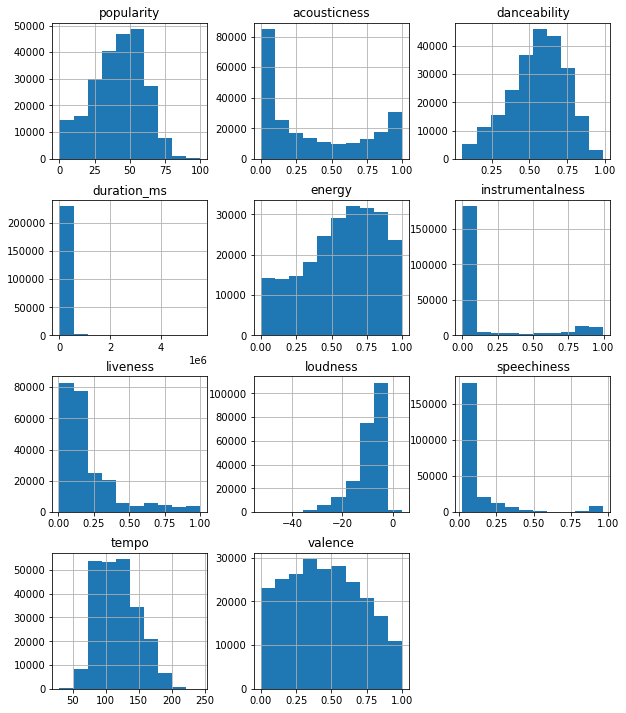

In [88]:
df_audio_feats.hist(figsize=(10,35),layout=(11,3));

Describe the final dataset that is used for classification/regression (include a
description of any newly formed variables you created).

## Modeling and Evaluation

### Task 1: Classifying Genre -- Multiclass

#### Evaluation Metrics
Choose and explain your evaluation metrics that you will use (i.e., accuracy,
precision, recall, F-measure, or any metric we have discussed). Why are the measure(s)
appropriate for analyzing the results of your modeling? Give a detailed explanation
backing up any assertions.


#### Methods
Choose the method you will use for dividing your data into training and
testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why
your chosen method is appropriate or use more than one method as appropriate.

#### Models
1. Create three different classification/regression models (e.g., random forest,
KNN, and SVM). Two modeling techniques must be new (but the third could be SVM or
logistic regression). Adjust parameters as appropriate to increase generalization
performance using your chosen metric.
* Analyze the results using your chosen method of evaluation. Use
visualizations of the results to bolster the analysis. Explain any visuals and analyze why
they are interesting to someone that might use this model.
* Discuss the advantages of each model for each classification task, if any. If
there are not advantages, explain why. Is any model better than another? Is the
difference significant with 95% confidence? Use proper statistical comparison methods.

##### Model 1

##### Model 2

##### Model 3

#### Important Dataset Features for Analysis
Which attributes from your analysis are most important? Use proper
methods discussed in class to evaluate the importance of different attributes. Discuss
the results and hypothesize about why certain attributes are more important than others
for a given classification task.

### Task 2: Regression -- Predicting Popularity
#### Evaluation Metrics
Choose and explain your evaluation metrics that you will use (i.e., accuracy,
precision, recall, F-measure, or any metric we have discussed). Why are the measure(s)
appropriate for analyzing the results of your modeling? Give a detailed explanation
backing up any assertions.

#### Methods
Choose the method you will use for dividing your data into training and
testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why
your chosen method is appropriate or use more than one method as appropriate.

**For feature selection, we will select the following features which are only based on music theory and not artist/song information: acousticness, danceability, duration_ms, energy, instrumentalness, key, liveliness, loudness, mode, speeciness, tempo, time_signature, and valence.**

In [ ]:
features = ["acousticness", "danceability", "duration_ms", "energy", "instrumentalness", "key", "liveness",
            "mode", "speechiness", "tempo", "time_signature", "valence"]

In [ ]:
training = df.sample(frac=0.8, random_state=420)
X_train = training[features]
y_train = training['popularity']
X_test = df.drop(training.index)[features]

X_train, X_valid, y_train, y_valid = train_test_split(X_train,
                                                      y_train,
                                                      test_size=0.2,
                                                      random_state=420)

#### Models
1. Create three different classification/regression models (e.g., random forest,
KNN, and SVM). Two modeling techniques must be new (but the third could be SVM or
logistic regression). Adjust parameters as appropriate to increase generalization
performance using your chosen metric.
* Analyze the results using your chosen method of evaluation. Use
visualizations of the results to bolster the analysis. Explain any visuals and analyze why
they are interesting to someone that might use this model.
* Discuss the advantages of each model for each classification task, if any. If
there are not advantages, explain why. Is any model better than another? Is the
difference significant with 95% confidence? Use proper statistical comparison methods.

##### Model 1: Logistic Regression

In [ ]:
LR_Model = LogisticRegression()
LR_Model.fit(X_train, y_train)
LR_Predict = LR_Model.predict(X_valid)
LR_Accuracy = accuracy_score(y_valid, LR_Predict)
print("Accuracy: " + str(LR_Accuracy))

LR_AUC = roc_auc_score(y_valid, LR_Predict)
print("AUC: " + str(LR_AUC))

##### Model 2: Random Forest

In [ ]:
# Random Forest Classifier
RFC_Model = RandomForestClassifier()
RFC_Model.fit(X_train, y_train)
RFC_Predict = RFC_Model.predict(X_valid)
RFC_Accuracy = accuracy_score(y_valid, RFC_Predict)
print("Accuracy: " + str(RFC_Accuracy))

RFC_AUC = roc_auc_score(y_valid, RFC_Predict)
print("AUC: " + str(RFC_AUC))

In [ ]:
# random forest for feature importance on a regression problem

# Trying to show the feature name instead of feature 1 , feature 2.
# TODO: Try if you can show the feature name in the plot

from matplotlib import pyplot

# define dataset
# get importance
importance = RFC_Model.feature_importances_
importance
# summarize feature importance
for i, v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i, v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

##### Model 3: XGBoost

#### Important Dataset Features for Analysis
Which attributes from your analysis are most important? Use proper
methods discussed in class to evaluate the importance of different attributes. Discuss
the results and hypothesize about why certain attributes are more important than others
for a given classification task.

## Deployment
How useful is your model for interested parties (i.e., the companies or
organizations that might want to use it for prediction)? How would you measure the
model's value if it was used by these parties? How would your deploy your model for
interested parties? What other data should be collected? How often would the model
need to be updated, etc.?

## Exceptional Work!
You have free reign to provide additional modeling.

**One idea:** grid search parameters in a parallelized fashion and visualize the
performances across attributes. Which parameters are most significant for making a
good model for each classification algorithm?